In this assignment, you'll get hands-on experience coding and training Generative Adversarial Networks or GANs. We will implement a specific type of GAN designed to process images, called a Deep Convolutional GAN (DCGAN). We'll train the DCGAN to generate natural images from CIFAR10. Let's get started. 


A GAN is a generative model that has the following network structure:

![discriminator](https://drive.google.com/uc?export=view&id=19LkOTaowOrNhIKvjXWvO6qhFVUNZMF5Y)

A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and a network composed of transposed convolutions as the generator. To implement the DCGAN, we need to specify three things: 


1.   the Discriminator
2.   the Generator
3.   the training Procedure



### Part 1: Implement the Discriminator of the DCGAN

The discriminator in the DCGAN you will implement is a convolutional neural network with the following architecture:

![discriminator](https://drive.google.com/uc?export=view&id=1KrqS_AyjHIm7leVh58pjVRmnGx-le1vB)


1.   **Padding**: In each of the convolutional layers shown above, we downsample the spatial dimension of the input volume by a factor of 2. Given that we kernel size $K=5$ and stride $S=2$, what should the padding be? Write your answer below in the colab, and show your work (i.e. the formula you used to derived the padding.)
2.   **Implementation**: Implement the above architecture in the ```define_discriminator``` routine below and return the model.






## **Answer**

To get the padding, we can use the equation we learned in class:

$r = \frac {n + 2p - f}{s}  + 1$,

to get the padding p:

$p = \frac {s(r-1) + f - n} {2}$,

where `s = stride = 2`, `f = kernel size = 5`, `p = padding`, `r = resultant dimension = 16`, and `n = input image dimensions = 32`

to get the following:

$p = 2$


#**Discriminator Implementation**

To define the discriminator, we note the following things about its structure from lecture:

- We can apply Batch Normalization everywhere except the discriminator input
- We use LeakyReLU for the discriminator

To build the model, we simply followed the diagram provided above, where we applies four convolutions. The last convolution we generated a 2x2x256, then applied `Flatten()` and then a FC layer.

In [ ]:
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
import numpy as np


def define_discriminator(input_shape=(32,32,3)):
	
	kernel = 5
	stride = 2

	assert input_shape == (32,32,3)
 
	# create model
	model = keras.Sequential()

	# 1st conv
	model.add(keras.layers.Conv2D(filters=32,kernel_size=kernel,padding='same',strides=stride,input_shape=(32,32,3)))
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	model.add(keras.layers.BatchNormalization())
	# print(f"1st conv2d: output_shape: {model.output_shape}")

	# 2nd conv
	model.add(keras.layers.Conv2D(filters=64,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	# print(f"2nd conv2d: output_shape: {model.output_shape}")

	# 3rd conv
	model.add(keras.layers.Conv2D(filters=128,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	# print(f"3rd conv2d: output_shape: {model.output_shape}")
	
	# 4th convolution
	model.add(keras.layers.Conv2D(filters=256,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
 
	# FC layer
	model.add(keras.layers.Flatten())
 
	# output
	model.add(keras.layers.Dense(1,activation='sigmoid'))
 
	# define optimizer
	opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1 = 0.6)
	model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['binary_accuracy'])

	return model


Using TensorFlow backend.


### Part 2: Implement the Generator

Now, we will implement the generator of the DCGAN in ```define_generator```, which consists of a sequence of transpose convolutional layers that progressively upsample the input noise sample to generate a fake image. Since the training of the generator involves an end-to-end cost function involving both the generator and the discriminator, you should also define a combined GAN model in ``define_gan``. Note that the discriminator portion is frozen (setting ``trainable`` to ``False``) as the weights of the discriminator are not modified during the training of the generator. The generator has the following architecture:

![discriminator](https://drive.google.com/uc?export=view&id=18RwpQChvU1FLfnCEfMiJKsKklsOkDyTS)



#**Generator Implementation**

To create the generator, we followed the structure presented in class, where:

- We apply Batch Normalization on all layers except for the generator output
- We apply ReLU through the generator except at the output
- At the output, we apply a `tanh` activation


To implement the generator, we also followed the diagram above and played around with the ReLU values. Since the input has an `input_shape` of dimenstion `100`, we made a dense layer and reshaped it to a 4x4x128. Then, we followed the diagram, following the number of filters, kernel stride, and kernel size as specified above. 

For the GAN, we set the discriminator training to `False` because we need to train the discriminator separately. In the GAN, we generate a latent vector of dimension 100 and put it through the generator. Then, we used the output fake image as the input to the discriminator to get a decision. This decision and the original latent vector are used to create the GAN model, since we want an output decision and a model that takes in a latent vector.

In [ ]:
# define the standalone generator model
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
import keras.initializers as initializers
import numpy as np

def define_generator(latent_dim=100):

    # create model   
    model = keras.Sequential()

    # reshape input to 4x4x128
    model.add(keras.layers.Dense(4*4*128, input_shape=(latent_dim,)))
    model.add(keras.layers.Reshape((4, 4, 128)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.3))
    # print(f"after linear and reshape: output_shape: {model.output_shape}")

    # 1st conv
    model.add(keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.3))
    # print(f"1st conv2d_transpose: output_shape: {model.output_shape}")
    
    # 2nd conv
    model.add(keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.3))
    # print(f"2nd conv2d_transpose: output_shape: {model.output_shape}")

    # 3rd conv
    model.add(keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))
    # print(f"3rd conv2d_transpose: output_shape: {model.output_shape}")

    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):

  # make weights in the discriminator not trainable
  d_model.trainable = False
  
  # Define your combined model here 
  x = keras.layers.Input(shape=(100,))
  img = g_model(x)
  decision = d_model(img)
  model = keras.models.Model(inputs=x,outputs=decision)

  model.compile(keras.optimizers.Adam(learning_rate=2e-4, beta_1 = 0.6), loss='binary_crossentropy', metrics=['binary_accuracy'])
  return model


# print out discriminator summary
discriminator = define_discriminator()
discriminator.summary()

# print out generator summary
generator = define_generator()
generator.summary()

# print out GAN summary
gan = define_gan(generator, discriminator)
gan.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)         

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Part 3: Training the model

Instantiate the following routine ``train`` to train a DCGAN. The basic procedure goes like the followings. For each batch in each epoch: 

1.   Randomly sample a batch size of real images and give each of them a "real" label
2.   Randomly generate a batch size of latent points and create fake images using the generator. Give each fake image a "fake" label.
3.   Use the data from 1 and 2 as training data to train only the discriminator 
4.   Randomly generate a batch size of latent points and create fake images using the generator. Give each fake image a "real" label.
5.   Use the data to train the combined network. 

To monitor the progress, print out the performance of the discriminator network every episode and five randomly generated images every 5 episodes. As the training may take a significant amount of time, please save all the models in ``outputdir`` every episode in case you need to stop and restart the training process. 


#**Training Implementation**

To train the model, we assume the input dataset `dataset` is already divided into batches. Then, we can iterate through all the batches per epoch. In a single epoch, we convert the batch into a `numpy` list. This batch contains the $real$ $images$ that we will train our disriminator on. The $real$ $images$ are input to the discriminator are given $real$ $labels$ of the value $1$. So we have something like:

`d_loss_real_imgs = d_model.train_on_batch(real_data, np.ones((batch_size,1))`

We do the same thing for $fake$ $images$, where we can generate fake images from the generator model. The output is given $label = 0$, where we have

`d_loss_fake_imgs = d_model.train_on_batch(fake_data, np.zeros((batch_size,1))`

For the GAN, we train it with the input (100,). In the GAN, fake images will be generated and we given then a real label and get the loss.


In [ ]:
import time
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
from keras.datasets import cifar10
import numpy as np

batch_size = 128

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, outputdir='/training_checkpoints/', latent_dim=100, n_epochs=200, n_batch=128):

  print(f"Number of epochs: {n_epochs}")
  print(f"Number of batches: {n_batch}")

  checkpoint_prefix = os.path.join(outputdir, "ckpt")
  model_filename = 'model_checkpoint'

  # go through all batches per epoch
  for epoch in range(n_epochs):

    start = time.time()

    # get a batch of real images and give them a real label
    for data_batch in dataset:

      # convert to numpy array
      # shape: 128x32x32x3
      data = np.stack(list(data_batch))

      # generate noise for creating fake images in step 2
      random_noise = np.random.normal(size=(n_batch,latent_dim))

      # train the discriminator
      d_model.training = True


      # compute the loss for the discriminator - compare the real images with a bunch of ones
      # ones are used to label 'real' images
      d_loss_real_imgs = d_model.train_on_batch(x=data, y=np.ones((128,1)))
      random_img = g_model.predict_on_batch(random_noise)
      d_loss_fake_imgs = d_model.train_on_batch(x=random_img, y=np.zeros((128,1)))

      loss = (d_loss_fake_imgs[0] + d_loss_real_imgs[0])

      d_model.training = False
      gan_loss = gan_model.train_on_batch(x=random_noise,y=np.ones((128,1)))

    print(f"epoch = {epoch+1}/{n_epochs}, d_loss={loss:0.3f}, g_loss={gan_loss[0]:0.3f}")

    if (epoch % 5 == 0):
        samples = 10
        x_fake = g_model.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

    if(epoch + 1 % 20 == 0):
      # we will save model checkpoints to continue training in case of kernel death
      model_filename_gan = 'gan_train.{0:03d}.hdf5'
      model_filename_g = 'generator_train.{0:03d}.hdf5'
      model_filename_d = 'discriminator_train.{0:03d}.hdf5'
      save_model(gan, model_filename_gan)
      save_model(gan, model_filename_g)
      save_model(gan, model_filename_d)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))





# Part 4: Experiment

This is where you put everything together and test it on CIFAR10. In the other part of the lab, you have already built a classifier for CIFAR10. For this experiment, you will use the same set of training images to build a DCGAN and then use the resulting generator to create 50,000 fake images. These fake images have no class labels but you can predict them using the classifier you built earlier. Now treating these fake images and predicted labels as training data, build a brand new classifier for CIFAR10 and compare its performance with the original one trained on the raw data. 

1.   Comment on any differences between their performances. Without running additional experiments, do you think the performance of the classifier trained on fake images will improve if you use 500,000 fake images instead of 50,000?
2.   You might wonder why anyone would use fake data to train classifier. As it turns out, this is a useful strategy to protect privacy of sensitive original data, especially in frederated learning when sensitive data need to be aggregated from many different sites. Inspecting a random set of fake images, do you think that they disclose any of the raw images from the original CIFAR10 dataset? 





#**Answers to Q1 and Q2**
1. Based on the results below, the images are much darker compared to the original CIFAR10 classifier trained on the original images. This is because the output images from the 100th epoch after training the DCGAN shows that the images are not clear and are dark in color. Our output from the generator is not that good. If we trained on 500k fake images from the generator, the output would not improve in this case, since the fake images are already wrong. If our DCGAN was well-trained though, then 500k results would improve the NN.

2. For a DCGAN that is working better than ours, then the output images generated by the GAN is different enough from the original images, so the raw images are not disclosed. Therefore, we can use the fake images instead of the original/raw images. Therefore, we believe that privacy comes in tandem with a well-trained model.


#**Experiment Implementation**

As mentioned in the previous instructions, what we did first was train a classifier, like in part 1

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

170500096/170498071 [==============================] - 4s 0us/step
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [ ]:
x_train2  = [((x/255) - 0.5) for x in x_train]
x_train2 = np.array(x_train2)
x_test2   = [((x/255) - 0.5) for x in x_test]
x_test2 = np.array(x_test2)

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
print(y_train2.shape)
y_test2 = keras.utils.to_categorical(y_test)
print(y_test2.shape)

(50000, 10)
(10000, 10)


## Classifier CNN architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU


def make_model():
    model = Sequential()

    NUM_CLASSES = 10

    model = Sequential()  # start feed-forward model definition

    model.add(keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"
    model.add(LeakyReLU(0.1))

    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    # model.add(Dense(256, input_shape=(50000,)))
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
    model.add(LeakyReLU(0.1))
    model.add(Activation("softmax"))  # output probabilities
    
    return model
  

In [ ]:
import tqdm
from collections import defaultdict

class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm.tqdm_notebook(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [ ]:
import tensorflow as tf
from keras.models import save_model

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

model = make_model()  # define our model
model.summary()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))


# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None
#print(f"x_test2: {len(x_test2)}")

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    #validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

# save weights to file
model.save_weights("weights.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Model saved in cifar.000.hdf5
Learning rate: 0.0045
Epoch 2/10



Model saved in cifar.001.hdf5
Learning rate: 0.00405
Epoch 3/10



Model saved in cifar.002.hdf5
Learning rate: 0.003645
Epoch 4/10



Model saved in cifar.003.hdf5
Learning rate: 0.0032805
Epoch 5/10



Model saved in cifar.004.hdf5
Learning rate: 0.00295245
Epoch 6/10



Model saved in cifar.005.hdf5
Learning rate: 0.002657205
Epoch 7/10



Model saved in cifar.006.hdf5
Learning rate: 0.0023914846
Epoch 8/10



Model saved in cifar.007.hdf5
Learning rate: 0.002152336
Epoch 9/10



Model saved in cifar.008.hdf5
Learning rate: 0.0019371024
Epoch 10/10



Model saved in cifar.009.hdf5


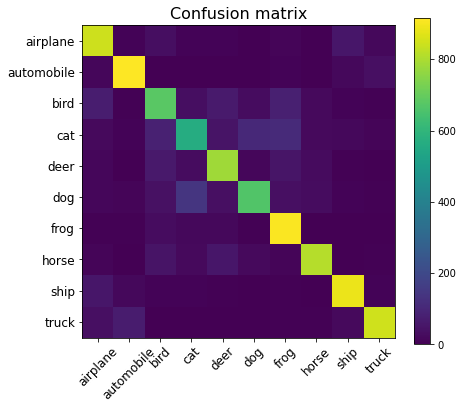

Test accuracy: 0.7919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


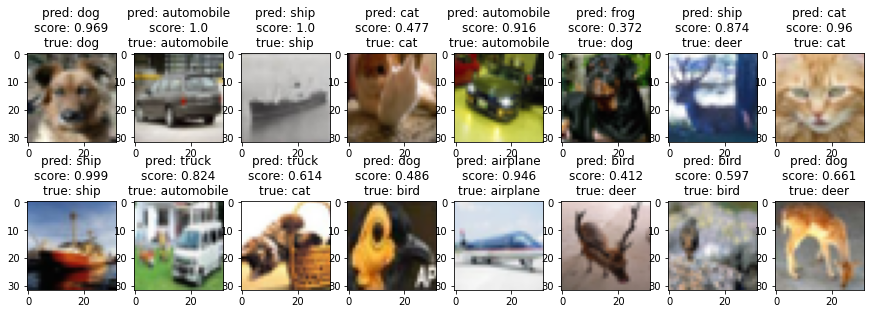

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(b=False)
        ax.axis(b=False)
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

#Experiment
The implementation for the experiment follows the steps below in the code given by the original problem description. Here we used the model of the c classifier obtained from lab4 part1, and then used it to train the fake images generated from the generator, and finally used the fake labels and the fake images to train the classifier c'. The result shows that the acccuracy of the classifier c is 0.7919 and the accuracy of the classifier c' is 0.1. In the training the epoch was set to 200 in order to see if there's an improved result compared to epoch = 100. However, the results were not improved much and the potential reson is due to the training for the original classifier still need to be improved in oder to get a better result for the classifier c'. 

C_Test accuracy: 0.7919
Number of samples to train: 50000
x_train shape: (50000, 32, 32, 3), type: <class 'numpy.ndarray'>
Number of epochs: 200
Number of batches: 128


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch = 1/200, d_loss=0.037, g_loss=0.705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


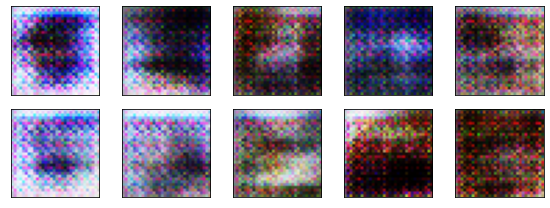

Time for epoch 1 is 27.208961009979248 sec
epoch = 2/200, d_loss=0.061, g_loss=2.663
Time for epoch 2 is 22.28157377243042 sec
epoch = 3/200, d_loss=0.452, g_loss=2.371
Time for epoch 3 is 22.220284938812256 sec
epoch = 4/200, d_loss=2.438, g_loss=4.777
Time for epoch 4 is 22.47215962409973 sec
epoch = 5/200, d_loss=0.471, g_loss=4.755
Time for epoch 5 is 22.239367485046387 sec
epoch = 6/200, d_loss=0.179, g_loss=0.995


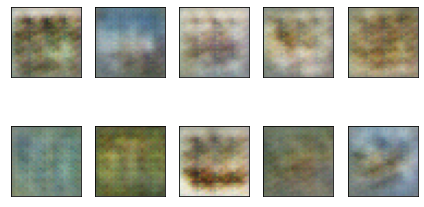

Time for epoch 6 is 22.338712453842163 sec
epoch = 7/200, d_loss=0.420, g_loss=6.698
Time for epoch 7 is 22.082552671432495 sec
epoch = 8/200, d_loss=0.098, g_loss=3.530
Time for epoch 8 is 22.10605001449585 sec
epoch = 9/200, d_loss=0.045, g_loss=11.037
Time for epoch 9 is 22.05837082862854 sec
epoch = 10/200, d_loss=0.095, g_loss=3.163
Time for epoch 10 is 22.124475240707397 sec
epoch = 11/200, d_loss=0.188, g_loss=4.541


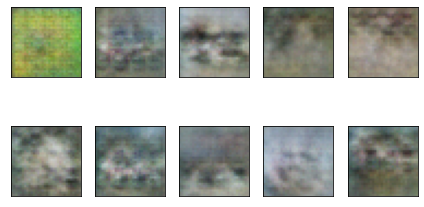

Time for epoch 11 is 22.491482734680176 sec
epoch = 12/200, d_loss=0.706, g_loss=4.712
Time for epoch 12 is 22.054751873016357 sec
epoch = 13/200, d_loss=0.710, g_loss=4.861
Time for epoch 13 is 21.98635959625244 sec
epoch = 14/200, d_loss=0.040, g_loss=4.211
Time for epoch 14 is 22.126089096069336 sec
epoch = 15/200, d_loss=0.999, g_loss=5.115
Time for epoch 15 is 22.070371627807617 sec
epoch = 16/200, d_loss=0.186, g_loss=4.110


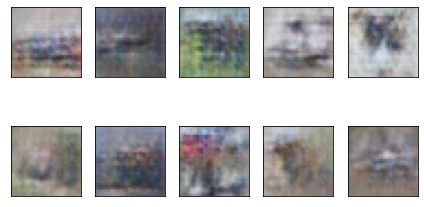

Time for epoch 16 is 22.35749125480652 sec
epoch = 17/200, d_loss=2.203, g_loss=10.020
Time for epoch 17 is 22.088850259780884 sec
epoch = 18/200, d_loss=0.168, g_loss=4.161
Time for epoch 18 is 22.520071506500244 sec
epoch = 19/200, d_loss=0.062, g_loss=2.796
Time for epoch 19 is 22.15037703514099 sec
epoch = 20/200, d_loss=0.045, g_loss=5.864
Time for epoch 20 is 22.072250366210938 sec
epoch = 21/200, d_loss=0.161, g_loss=3.023


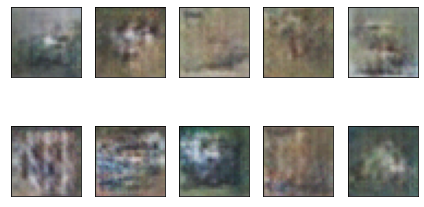

Time for epoch 21 is 22.513431072235107 sec
epoch = 22/200, d_loss=0.355, g_loss=4.073
Time for epoch 22 is 22.111181259155273 sec
epoch = 23/200, d_loss=0.075, g_loss=2.635
Time for epoch 23 is 22.022759199142456 sec
epoch = 24/200, d_loss=0.193, g_loss=3.559
Time for epoch 24 is 22.082342386245728 sec
epoch = 25/200, d_loss=0.043, g_loss=3.112
Time for epoch 25 is 22.237226724624634 sec
epoch = 26/200, d_loss=0.059, g_loss=3.150


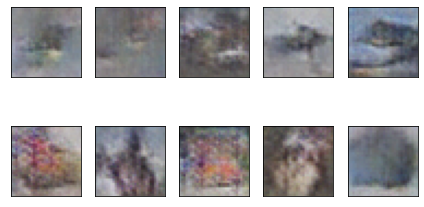

Time for epoch 26 is 22.58799457550049 sec
epoch = 27/200, d_loss=1.894, g_loss=0.934
Time for epoch 27 is 22.090595483779907 sec
epoch = 28/200, d_loss=0.107, g_loss=3.888
Time for epoch 28 is 22.140191078186035 sec
epoch = 29/200, d_loss=0.140, g_loss=4.500
Time for epoch 29 is 22.20280122756958 sec
epoch = 30/200, d_loss=0.062, g_loss=3.049
Time for epoch 30 is 22.09001350402832 sec
epoch = 31/200, d_loss=0.246, g_loss=6.068


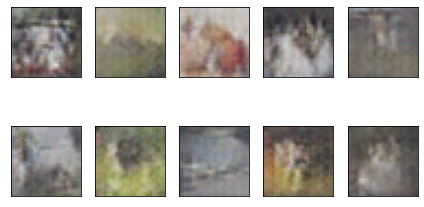

Time for epoch 31 is 22.459190845489502 sec
epoch = 32/200, d_loss=0.082, g_loss=5.291
Time for epoch 32 is 22.44881820678711 sec
epoch = 33/200, d_loss=0.114, g_loss=3.652
Time for epoch 33 is 22.18885087966919 sec
epoch = 34/200, d_loss=0.201, g_loss=4.315
Time for epoch 34 is 22.082072019577026 sec
epoch = 35/200, d_loss=1.937, g_loss=3.309
Time for epoch 35 is 22.052323579788208 sec
epoch = 36/200, d_loss=1.312, g_loss=1.967


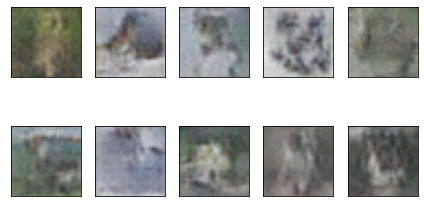

Time for epoch 36 is 22.433348417282104 sec
epoch = 37/200, d_loss=0.359, g_loss=4.419
Time for epoch 37 is 22.041910886764526 sec
epoch = 38/200, d_loss=0.061, g_loss=4.150
Time for epoch 38 is 21.99920129776001 sec
epoch = 39/200, d_loss=1.394, g_loss=0.958
Time for epoch 39 is 22.052817344665527 sec
epoch = 40/200, d_loss=0.110, g_loss=3.731
Time for epoch 40 is 22.111531734466553 sec
epoch = 41/200, d_loss=1.112, g_loss=8.156


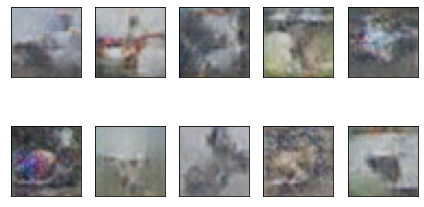

Time for epoch 41 is 22.3816077709198 sec
epoch = 42/200, d_loss=0.025, g_loss=6.048
Time for epoch 42 is 22.046173095703125 sec
epoch = 43/200, d_loss=0.087, g_loss=3.273
Time for epoch 43 is 22.192026138305664 sec
epoch = 44/200, d_loss=0.035, g_loss=5.653
Time for epoch 44 is 22.044325828552246 sec
epoch = 45/200, d_loss=0.095, g_loss=3.457
Time for epoch 45 is 22.063363313674927 sec
epoch = 46/200, d_loss=0.045, g_loss=4.569


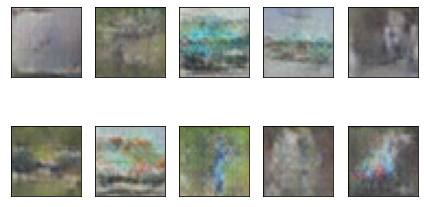

Time for epoch 46 is 22.822527647018433 sec
epoch = 47/200, d_loss=0.418, g_loss=7.494
Time for epoch 47 is 22.183134078979492 sec
epoch = 48/200, d_loss=0.356, g_loss=2.658
Time for epoch 48 is 21.983710289001465 sec
epoch = 49/200, d_loss=0.124, g_loss=3.743
Time for epoch 49 is 22.050642728805542 sec
epoch = 50/200, d_loss=0.041, g_loss=3.822
Time for epoch 50 is 22.026289224624634 sec
epoch = 51/200, d_loss=0.181, g_loss=3.946


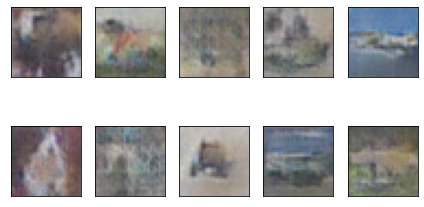

Time for epoch 51 is 22.37041401863098 sec
epoch = 52/200, d_loss=0.085, g_loss=3.928
Time for epoch 52 is 21.9593403339386 sec
epoch = 53/200, d_loss=0.020, g_loss=5.539
Time for epoch 53 is 21.928356170654297 sec
epoch = 54/200, d_loss=0.181, g_loss=3.967
Time for epoch 54 is 22.05112910270691 sec
epoch = 55/200, d_loss=0.063, g_loss=4.525
Time for epoch 55 is 22.002501964569092 sec
epoch = 56/200, d_loss=0.129, g_loss=3.466


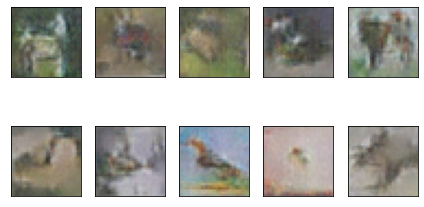

Time for epoch 56 is 22.310615301132202 sec
epoch = 57/200, d_loss=2.670, g_loss=2.872
Time for epoch 57 is 22.10207986831665 sec
epoch = 58/200, d_loss=0.099, g_loss=5.704
Time for epoch 58 is 22.092454195022583 sec
epoch = 59/200, d_loss=0.041, g_loss=4.280
Time for epoch 59 is 22.027704000473022 sec
epoch = 60/200, d_loss=0.010, g_loss=8.304
Time for epoch 60 is 22.372844219207764 sec
epoch = 61/200, d_loss=0.128, g_loss=3.943


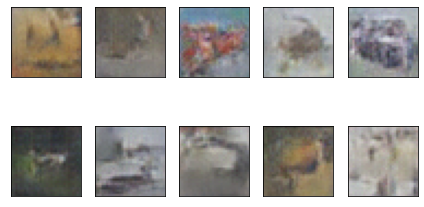

Time for epoch 61 is 22.593351364135742 sec
epoch = 62/200, d_loss=0.139, g_loss=2.883
Time for epoch 62 is 22.031730890274048 sec
epoch = 63/200, d_loss=0.081, g_loss=7.051
Time for epoch 63 is 22.008387327194214 sec
epoch = 64/200, d_loss=4.436, g_loss=9.080
Time for epoch 64 is 21.845458984375 sec
epoch = 65/200, d_loss=0.028, g_loss=6.700
Time for epoch 65 is 22.09499430656433 sec
epoch = 66/200, d_loss=1.338, g_loss=11.132


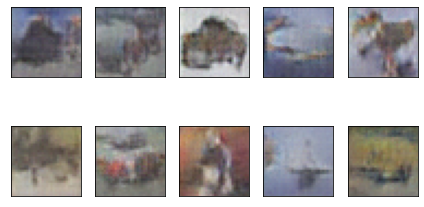

Time for epoch 66 is 22.25756072998047 sec
epoch = 67/200, d_loss=0.106, g_loss=6.953
Time for epoch 67 is 22.0102276802063 sec
epoch = 68/200, d_loss=0.947, g_loss=2.600
Time for epoch 68 is 22.00139570236206 sec
epoch = 69/200, d_loss=0.023, g_loss=3.141
Time for epoch 69 is 22.1387197971344 sec
epoch = 70/200, d_loss=0.093, g_loss=4.490
Time for epoch 70 is 22.06877899169922 sec
epoch = 71/200, d_loss=0.104, g_loss=5.292


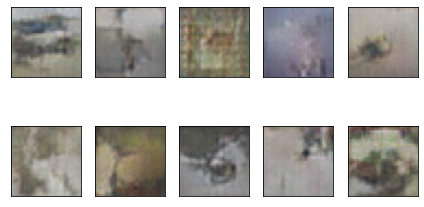

Time for epoch 71 is 22.422122716903687 sec
epoch = 72/200, d_loss=0.133, g_loss=2.825
Time for epoch 72 is 22.15369749069214 sec
epoch = 73/200, d_loss=0.146, g_loss=3.000
Time for epoch 73 is 22.007413864135742 sec
epoch = 74/200, d_loss=0.051, g_loss=7.878
Time for epoch 74 is 22.413442850112915 sec
epoch = 75/200, d_loss=0.502, g_loss=2.517
Time for epoch 75 is 21.965222120285034 sec
epoch = 76/200, d_loss=0.004, g_loss=5.758


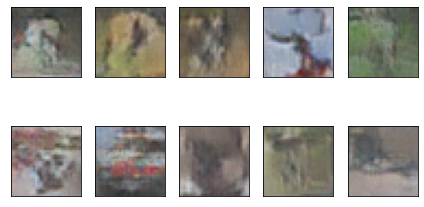

Time for epoch 76 is 22.57734990119934 sec
epoch = 77/200, d_loss=0.300, g_loss=5.230
Time for epoch 77 is 22.017796754837036 sec
epoch = 78/200, d_loss=0.170, g_loss=2.237
Time for epoch 78 is 22.029086112976074 sec
epoch = 79/200, d_loss=0.804, g_loss=6.925
Time for epoch 79 is 22.137776374816895 sec
epoch = 80/200, d_loss=0.045, g_loss=4.121
Time for epoch 80 is 22.103135108947754 sec
epoch = 81/200, d_loss=0.115, g_loss=4.289


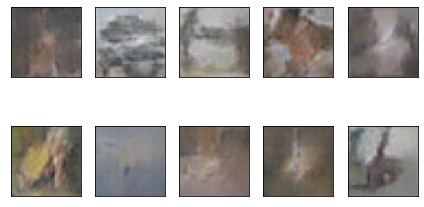

Time for epoch 81 is 22.338427782058716 sec
epoch = 82/200, d_loss=0.253, g_loss=5.372
Time for epoch 82 is 22.00094199180603 sec
epoch = 83/200, d_loss=0.039, g_loss=3.903
Time for epoch 83 is 22.13265037536621 sec
epoch = 84/200, d_loss=0.166, g_loss=4.819
Time for epoch 84 is 22.016452312469482 sec
epoch = 85/200, d_loss=0.021, g_loss=5.394
Time for epoch 85 is 22.01001286506653 sec
epoch = 86/200, d_loss=0.132, g_loss=6.151


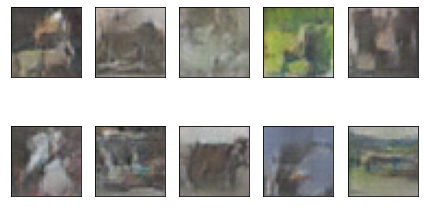

Time for epoch 86 is 22.298798084259033 sec
epoch = 87/200, d_loss=0.045, g_loss=3.229
Time for epoch 87 is 22.168566465377808 sec
epoch = 88/200, d_loss=0.067, g_loss=1.984
Time for epoch 88 is 22.51151180267334 sec
epoch = 89/200, d_loss=0.016, g_loss=2.286
Time for epoch 89 is 22.043036460876465 sec
epoch = 90/200, d_loss=0.245, g_loss=6.612
Time for epoch 90 is 22.051196098327637 sec
epoch = 91/200, d_loss=0.103, g_loss=3.662


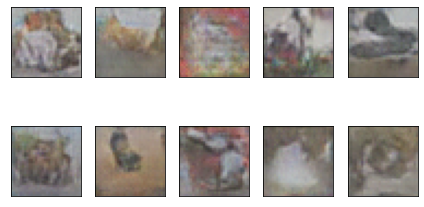

Time for epoch 91 is 22.417205572128296 sec
epoch = 92/200, d_loss=0.011, g_loss=3.139
Time for epoch 92 is 22.070526123046875 sec
epoch = 93/200, d_loss=0.029, g_loss=4.475
Time for epoch 93 is 21.986058950424194 sec
epoch = 94/200, d_loss=0.044, g_loss=4.188
Time for epoch 94 is 22.22503685951233 sec
epoch = 95/200, d_loss=0.025, g_loss=4.698
Time for epoch 95 is 22.038543939590454 sec
epoch = 96/200, d_loss=0.077, g_loss=7.612


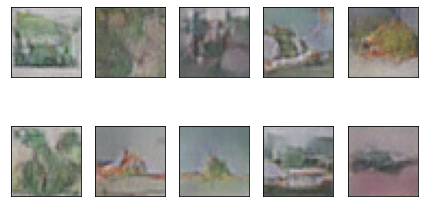

Time for epoch 96 is 22.352109670639038 sec
epoch = 97/200, d_loss=0.062, g_loss=4.909
Time for epoch 97 is 22.07693099975586 sec
epoch = 98/200, d_loss=0.076, g_loss=4.164
Time for epoch 98 is 22.132145404815674 sec
epoch = 99/200, d_loss=0.290, g_loss=2.923
Time for epoch 99 is 22.034344911575317 sec
epoch = 100/200, d_loss=0.024, g_loss=3.781
Time for epoch 100 is 22.039125204086304 sec
epoch = 101/200, d_loss=0.145, g_loss=3.796


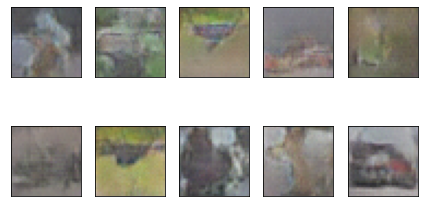

Time for epoch 101 is 22.62761902809143 sec
epoch = 102/200, d_loss=0.130, g_loss=5.184
Time for epoch 102 is 22.548553705215454 sec
epoch = 103/200, d_loss=0.182, g_loss=5.331
Time for epoch 103 is 21.987661123275757 sec
epoch = 104/200, d_loss=0.005, g_loss=5.379
Time for epoch 104 is 22.027232885360718 sec
epoch = 105/200, d_loss=0.010, g_loss=5.203
Time for epoch 105 is 22.109609127044678 sec
epoch = 106/200, d_loss=0.184, g_loss=4.810


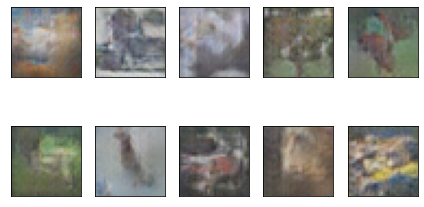

Time for epoch 106 is 22.35436224937439 sec
epoch = 107/200, d_loss=0.142, g_loss=4.227
Time for epoch 107 is 21.95903205871582 sec
epoch = 108/200, d_loss=0.012, g_loss=6.052
Time for epoch 108 is 21.989375352859497 sec
epoch = 109/200, d_loss=0.100, g_loss=3.657
Time for epoch 109 is 22.08663320541382 sec
epoch = 110/200, d_loss=0.012, g_loss=5.365
Time for epoch 110 is 22.097540855407715 sec
epoch = 111/200, d_loss=0.022, g_loss=2.948


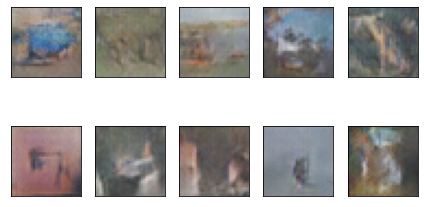

Time for epoch 111 is 22.241241455078125 sec
epoch = 112/200, d_loss=0.007, g_loss=4.202
Time for epoch 112 is 22.135008811950684 sec
epoch = 113/200, d_loss=0.052, g_loss=5.698
Time for epoch 113 is 22.045991897583008 sec
epoch = 114/200, d_loss=0.032, g_loss=9.188
Time for epoch 114 is 21.97844099998474 sec
epoch = 115/200, d_loss=0.038, g_loss=6.278
Time for epoch 115 is 22.15422511100769 sec
epoch = 116/200, d_loss=0.017, g_loss=4.524


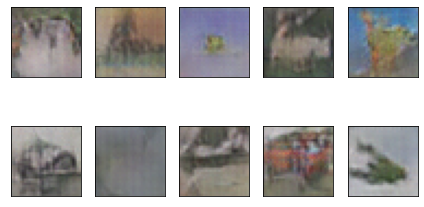

Time for epoch 116 is 22.793048858642578 sec
epoch = 117/200, d_loss=0.914, g_loss=0.604
Time for epoch 117 is 21.963701486587524 sec
epoch = 118/200, d_loss=0.022, g_loss=5.153
Time for epoch 118 is 22.05264949798584 sec
epoch = 119/200, d_loss=0.760, g_loss=6.569
Time for epoch 119 is 22.132078170776367 sec
epoch = 120/200, d_loss=0.018, g_loss=2.921
Time for epoch 120 is 22.073970317840576 sec
epoch = 121/200, d_loss=0.092, g_loss=6.009


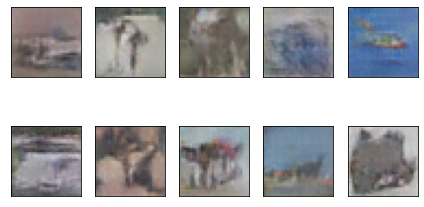

Time for epoch 121 is 22.397229433059692 sec
epoch = 122/200, d_loss=0.302, g_loss=3.308
Time for epoch 122 is 22.002866744995117 sec
epoch = 123/200, d_loss=0.040, g_loss=5.947
Time for epoch 123 is 22.16069483757019 sec
epoch = 124/200, d_loss=0.018, g_loss=5.099
Time for epoch 124 is 22.04851746559143 sec
epoch = 125/200, d_loss=0.137, g_loss=6.674
Time for epoch 125 is 22.08755397796631 sec
epoch = 126/200, d_loss=0.113, g_loss=6.130


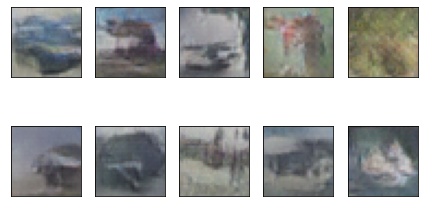

Time for epoch 126 is 22.454267024993896 sec
epoch = 127/200, d_loss=0.011, g_loss=5.543
Time for epoch 127 is 22.239970445632935 sec
epoch = 128/200, d_loss=0.086, g_loss=5.165
Time for epoch 128 is 22.009458541870117 sec
epoch = 129/200, d_loss=0.058, g_loss=3.904
Time for epoch 129 is 22.223913192749023 sec
epoch = 130/200, d_loss=0.125, g_loss=3.332
Time for epoch 130 is 22.40048885345459 sec
epoch = 131/200, d_loss=0.008, g_loss=5.481


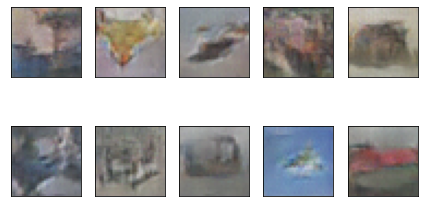

Time for epoch 131 is 22.451927661895752 sec
epoch = 132/200, d_loss=0.030, g_loss=7.215
Time for epoch 132 is 22.13469123840332 sec
epoch = 133/200, d_loss=0.046, g_loss=4.994
Time for epoch 133 is 22.200580596923828 sec
epoch = 134/200, d_loss=0.128, g_loss=4.453
Time for epoch 134 is 22.220062255859375 sec
epoch = 135/200, d_loss=0.113, g_loss=6.484
Time for epoch 135 is 22.03559374809265 sec
epoch = 136/200, d_loss=1.685, g_loss=2.171


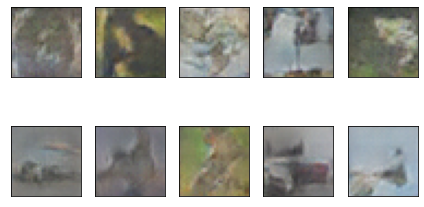

Time for epoch 136 is 22.626760482788086 sec
epoch = 137/200, d_loss=0.033, g_loss=1.595
Time for epoch 137 is 22.11868119239807 sec
epoch = 138/200, d_loss=0.094, g_loss=1.990
Time for epoch 138 is 22.232731580734253 sec
epoch = 139/200, d_loss=0.027, g_loss=6.429
Time for epoch 139 is 22.085831880569458 sec
epoch = 140/200, d_loss=0.010, g_loss=6.578
Time for epoch 140 is 22.04744267463684 sec
epoch = 141/200, d_loss=0.336, g_loss=4.154


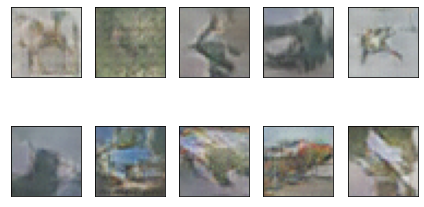

Time for epoch 141 is 22.43192720413208 sec
epoch = 142/200, d_loss=0.158, g_loss=6.931
Time for epoch 142 is 22.09919023513794 sec
epoch = 143/200, d_loss=0.011, g_loss=2.974
Time for epoch 143 is 22.249690294265747 sec
epoch = 144/200, d_loss=0.024, g_loss=5.003
Time for epoch 144 is 22.4210102558136 sec
epoch = 145/200, d_loss=0.019, g_loss=6.395
Time for epoch 145 is 22.143590211868286 sec
epoch = 146/200, d_loss=0.557, g_loss=4.212


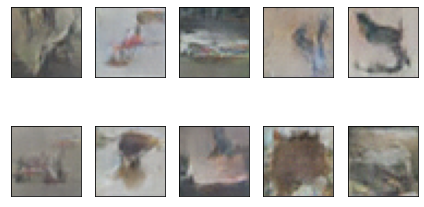

Time for epoch 146 is 22.454092025756836 sec
epoch = 147/200, d_loss=0.954, g_loss=0.839
Time for epoch 147 is 22.047722339630127 sec
epoch = 148/200, d_loss=0.049, g_loss=4.304
Time for epoch 148 is 22.155526399612427 sec
epoch = 149/200, d_loss=0.292, g_loss=4.568
Time for epoch 149 is 22.15128493309021 sec
epoch = 150/200, d_loss=0.022, g_loss=6.511
Time for epoch 150 is 22.097418785095215 sec
epoch = 151/200, d_loss=0.064, g_loss=5.465


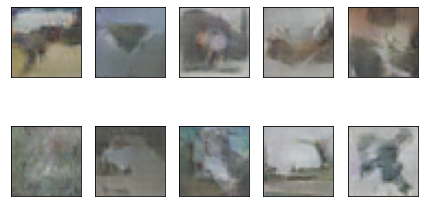

Time for epoch 151 is 22.46484136581421 sec
epoch = 152/200, d_loss=0.017, g_loss=8.651
Time for epoch 152 is 22.29729676246643 sec
epoch = 153/200, d_loss=0.043, g_loss=4.715
Time for epoch 153 is 22.12705683708191 sec
epoch = 154/200, d_loss=0.329, g_loss=3.550
Time for epoch 154 is 22.124842882156372 sec
epoch = 155/200, d_loss=0.120, g_loss=3.967
Time for epoch 155 is 22.10716152191162 sec
epoch = 156/200, d_loss=0.003, g_loss=6.365


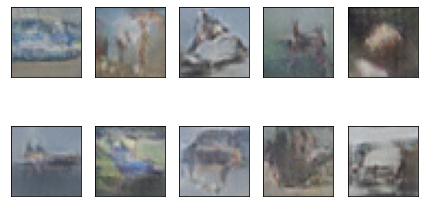

Time for epoch 156 is 22.53964900970459 sec
epoch = 157/200, d_loss=0.032, g_loss=4.998
Time for epoch 157 is 22.306552410125732 sec
epoch = 158/200, d_loss=0.074, g_loss=3.639
Time for epoch 158 is 22.405561447143555 sec
epoch = 159/200, d_loss=0.103, g_loss=2.331
Time for epoch 159 is 22.18218493461609 sec
epoch = 160/200, d_loss=0.073, g_loss=4.835
Time for epoch 160 is 22.211883306503296 sec
epoch = 161/200, d_loss=0.354, g_loss=5.000


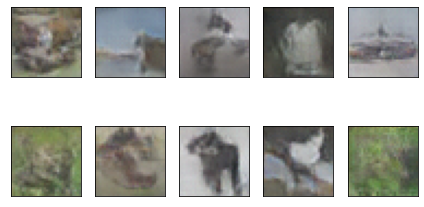

Time for epoch 161 is 22.39517903327942 sec
epoch = 162/200, d_loss=0.028, g_loss=5.815
Time for epoch 162 is 22.16826319694519 sec
epoch = 163/200, d_loss=1.258, g_loss=6.524
Time for epoch 163 is 22.266983032226562 sec
epoch = 164/200, d_loss=0.145, g_loss=6.049
Time for epoch 164 is 22.09624695777893 sec
epoch = 165/200, d_loss=0.163, g_loss=4.790
Time for epoch 165 is 22.065078258514404 sec
epoch = 166/200, d_loss=0.233, g_loss=1.963


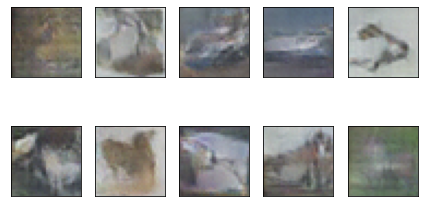

Time for epoch 166 is 22.353906631469727 sec
epoch = 167/200, d_loss=0.012, g_loss=6.720
Time for epoch 167 is 22.24888253211975 sec
epoch = 168/200, d_loss=0.104, g_loss=5.701
Time for epoch 168 is 22.09874653816223 sec
epoch = 169/200, d_loss=0.042, g_loss=3.200
Time for epoch 169 is 22.064234018325806 sec
epoch = 170/200, d_loss=0.110, g_loss=3.338
Time for epoch 170 is 22.21549391746521 sec
epoch = 171/200, d_loss=0.036, g_loss=4.751


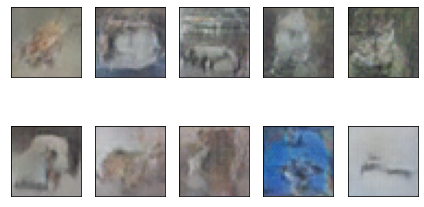

Time for epoch 171 is 22.320852279663086 sec
epoch = 172/200, d_loss=0.019, g_loss=5.535
Time for epoch 172 is 22.3873233795166 sec
epoch = 173/200, d_loss=0.017, g_loss=6.272
Time for epoch 173 is 22.061077117919922 sec
epoch = 174/200, d_loss=4.611, g_loss=0.265
Time for epoch 174 is 22.152738571166992 sec
epoch = 175/200, d_loss=0.015, g_loss=4.770
Time for epoch 175 is 22.06525468826294 sec
epoch = 176/200, d_loss=0.283, g_loss=3.317


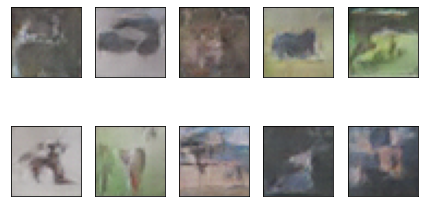

Time for epoch 176 is 22.595273971557617 sec
epoch = 177/200, d_loss=0.014, g_loss=4.477
Time for epoch 177 is 22.074384927749634 sec
epoch = 178/200, d_loss=0.749, g_loss=5.644
Time for epoch 178 is 22.0178382396698 sec
epoch = 179/200, d_loss=0.002, g_loss=5.219
Time for epoch 179 is 22.067163228988647 sec
epoch = 180/200, d_loss=0.121, g_loss=5.234
Time for epoch 180 is 22.062042236328125 sec
epoch = 181/200, d_loss=0.139, g_loss=5.847


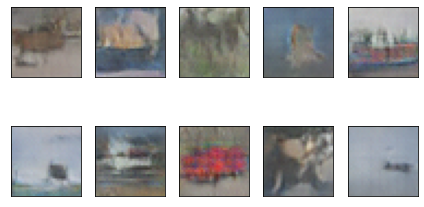

Time for epoch 181 is 22.578566551208496 sec
epoch = 182/200, d_loss=0.022, g_loss=7.534
Time for epoch 182 is 22.05174469947815 sec
epoch = 183/200, d_loss=0.009, g_loss=3.489
Time for epoch 183 is 22.052496433258057 sec
epoch = 184/200, d_loss=0.003, g_loss=5.255
Time for epoch 184 is 22.143333673477173 sec
epoch = 185/200, d_loss=0.020, g_loss=3.096
Time for epoch 185 is 22.181421518325806 sec
epoch = 186/200, d_loss=0.032, g_loss=5.014


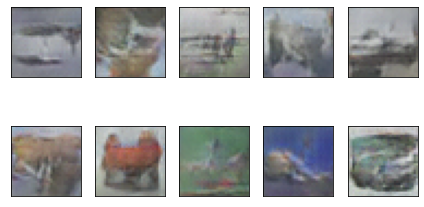

Time for epoch 186 is 22.778589963912964 sec
epoch = 187/200, d_loss=0.023, g_loss=5.438
Time for epoch 187 is 22.090314626693726 sec
epoch = 188/200, d_loss=0.066, g_loss=3.103
Time for epoch 188 is 22.159498929977417 sec
epoch = 189/200, d_loss=0.078, g_loss=2.316
Time for epoch 189 is 22.127928018569946 sec
epoch = 190/200, d_loss=0.050, g_loss=4.187
Time for epoch 190 is 22.076632499694824 sec
epoch = 191/200, d_loss=0.707, g_loss=6.907


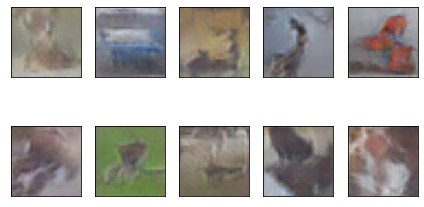

Time for epoch 191 is 22.30621361732483 sec
epoch = 192/200, d_loss=0.002, g_loss=4.765
Time for epoch 192 is 22.184732913970947 sec
epoch = 193/200, d_loss=0.046, g_loss=4.732
Time for epoch 193 is 21.98409605026245 sec
epoch = 194/200, d_loss=0.021, g_loss=5.525
Time for epoch 194 is 22.021427392959595 sec
epoch = 195/200, d_loss=2.337, g_loss=6.128
Time for epoch 195 is 22.03875994682312 sec
epoch = 196/200, d_loss=0.059, g_loss=4.834


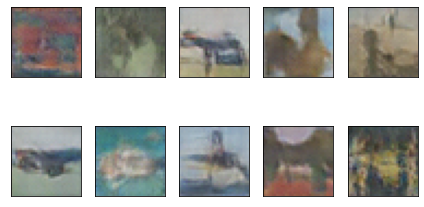

Time for epoch 196 is 22.5181245803833 sec
epoch = 197/200, d_loss=0.384, g_loss=3.492
Time for epoch 197 is 22.164019346237183 sec
epoch = 198/200, d_loss=0.037, g_loss=7.467
Time for epoch 198 is 22.22176241874695 sec
epoch = 199/200, d_loss=0.230, g_loss=5.671
Time for epoch 199 is 22.023041486740112 sec
epoch = 200/200, d_loss=0.092, g_loss=4.819
Time for epoch 200 is 22.50679063796997 sec


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50000, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with R

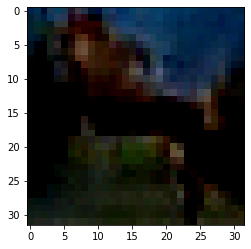

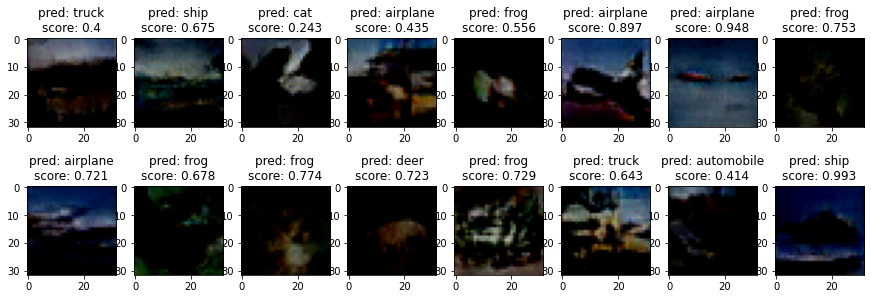

[7 5 1 ... 8 9 9]
(50000, 1) fake train
(50000, 10)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Model saved in cifar.000.hdf5
Learning rate: 0.0045
Epoch 2/10



Model saved in cifar.001.hdf5
Learning rate: 0.00405
Epoch 3/10



Model saved in cifar.002.hdf5
Learning rate: 0.003645
Epoch 4/10



Model saved in cifar.003.hdf5
Learning rate: 0.0032805
Epoch 5/10



Model saved in cifar.004.hdf5
Learning rate: 0.00295245
Epoch 6/10



Model saved in cifar.005.hdf5
Learning rate: 0.002657205
Epoch 7/10



Model saved in cifar.006.hdf5
Learning rate: 0.0023914846
Epoch 8/10



Model saved in cifar.007.hdf5
Learning rate: 0.002152336
Epoch 9/10



Model saved in cifar.008.hdf5
Learning rate: 0.0019371024
Epoch 10/10



Model saved in cifar.009.hdf5
Test accuracy: 0.1


In [ ]:
# Step 1: Train a classifier C for CIFAR10 from scratch using (x_train, y_train)
# Step 2: Use x_train to train a GAN with latent dimension = 100 for 200 epochs
# Step 3: Generate 50,000 fake image samples
# Step 4: Use C to produce labels for all fake images
# Step 5: Train a classifier C' from scratch using the fake images and the predicted labels
# Step 6: Compare C and C' on (x_test, y_test)

# Import the libraries
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.datasets import cifar10
import numpy as np

# x_test for the original classifier c
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
print("C_Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

#CIFAR10 data set contains 50k 32x32 images in the training set, and 10k images in the test set
num_imgs = 50000

print(f"Number of samples to train: {x_train.shape[0]}")

fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(x_train[i])
    
plt.tight_layout()

# reshape the training input and cast as float32
print(f"x_train shape: {x_train.shape}, type: {type(x_train)}")

# normalize the training input
x_train = (np.float32(x_train)/255) - 0.5
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(num_imgs).batch(batch_size, drop_remainder=True)

# get number of batches
num_batch = num_imgs // batch_size

# define all the models
generator = define_generator()
discriminator = define_discriminator()


gan = define_gan(generator,discriminator)

#train the models
train(g_model=generator, d_model=discriminator, gan_model=gan, dataset=x_train, n_batch=batch_size)
    

# Step 3: Generate 50,000 fake image samples
latent_dim = 100
num_imgs = 50000
random_noise = np.random.normal(size=(num_imgs,latent_dim))
random_img = generator.predict_on_batch(random_noise)
random_noise2 = np.random.normal(size=(10000,latent_dim))
random_img2 = generator.predict_on_batch(random_noise2)
x_fake_train = random_img
print(np.shape(random_img))
plt.imshow(random_img[0])


# inspect preditions
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Step 4: Use C to produce labels for all fake images
# make test predictions
x_train2 = x_fake_train
y_pred_test = model.predict_proba(x_train2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)


cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, 50000)
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(b=False)
        ax.axis(b=False)
        ax.imshow(x_train2[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        ax.set_title("pred: {}\nscore: {:.3}".format(
              pred_label, pred_proba
       ))
plt.show()

# Step 5: Train a classifier C' from scratch using the fake images and the predicted labels
pred_label = y_pred_test_classes[:]
print(pred_label)
y_fake_train = pred_label
y_fake_train = np.reshape(y_fake_train,(50000,1))
x_train2  = [((x/255) - 0.5) for x in x_train2]
x_train2 = np.array(x_train2)

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_fake_train)
print(np.shape(y_fake_train),'fake train')
print(y_train2.shape)


INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

model1 = make_model()  # define our model
model1.summary()

# prepare model for fitting (loss, optimizer, etc)
model1.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model1.optimizer.lr))


# we will save model checkpoints to continue training in case of kernel death
model1_filename = 'fake_cifar.{0:03d}.hdf5'
last_finished_epoch = None
print(f"x_test2: {len(x_test2)}")

# fit model
model1.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    #validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

# save weights to file
model1.save_weights("fake_weights.h5")

# x_test for the original classifier c'
y__fake_pred_test = model1.predict_proba(x_test2)
y__fake_pred_test_classes = np.argmax(y__fake_pred_test, axis=1)
y__fake_pred_test_max_probas = np.max(y__fake_pred_test, axis=1)


# Step 6: Compare C and C' on (x_test, y_test)
print("C_Test accuracy:", accuracy_score(y_test, y_pred_test_classes))
print("C' = Test accuracy:", accuracy_score(y_test, y__fake_pred_test_classes))



#**Visualize Class Activiation Map**

Using the code described in 

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb 

Implement the class activation map (CAM) to show the parts of the test images above that led your CNN to its final classification decision

In [ ]:
from keras.models import load_model

model = load_model('cifar.009.hdf5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 32)       

Shape of the image: (32, 32, 3)


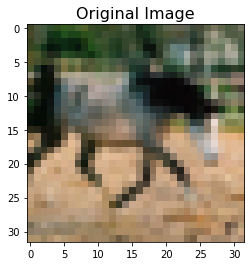

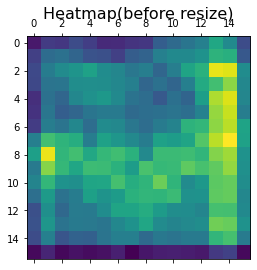

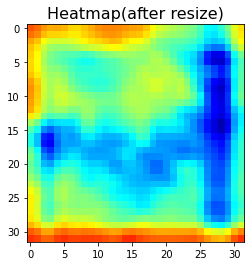

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


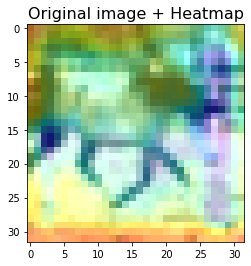

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Show a horse image x_train[52].
plt.imshow(x_train[52])
plt.title('Original Image', fontsize=16)

# Import the libraries
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2

# Pick a horse image x_train[52] to show the heatmap.
img = x_train[52]
print('Shape of the image:', np.shape(img))

# 'x' is a numpy array of shape (32, 32, 3)
x = image.img_to_array(img)

# A dimension was added to increse the "batch", the dimension of the array is now (1, 32, 32, 3)
x = np.expand_dims(x, axis=0)

# This is the "horse" entry in the prediction vector, 7 is the class of horse
horse = model.output[:, 7]

# This is the output feature map of the 'conv2d_16' layer,
# the last convolutional layer in our architecture
last_conv_layer = model.get_layer('conv2d_16')

# This is the gradient of the "horse" class with regard to
# the output feature map of 'conv2d_16'
grads = K.gradients(horse, last_conv_layer.output)[0]


# This is a vector of shape (64,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# 'pooled_grads' and the output feature map of 'conv2d_16', given a sample image.
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of one horse
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array by "how important this channel is" with regard to the horse class
for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis= -1)

heatmap = np.abs(heatmap)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.title('Heatmap(before resize)', fontsize=16)
plt.show()


# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
#print(np.shape(heatmap),'after resize')
plt.imshow(heatmap)
plt.title('Heatmap(after resize)', fontsize=16)
plt.show()
superimposed_img = heatmap * 0.4 + img

superimposed_img = superimposed_img.astype(int)

# Save the image to disk
plt.imshow(superimposed_img)
plt.title('Original image + Heatmap', fontsize=16)
plt.show()
